In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [2]:
image_size = 128
batch_size = 128

dataset = ImageFolder(
    root="data", 
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

dataloader = DataLoader(dataset, batch_size, shuffle=True)


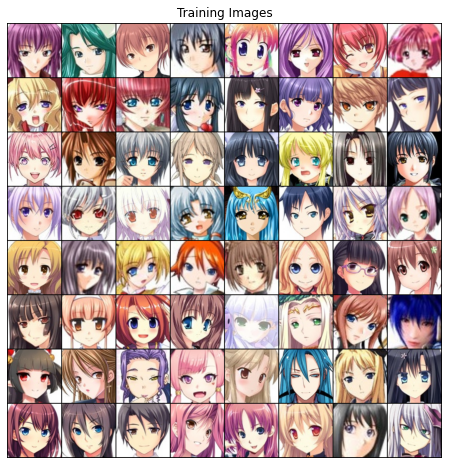

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

show_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(show_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
input_size = 128

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(input_size, 512, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
    
    def forward(self, x):
        return self.main(x)


In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)
        

In [6]:
def weights_init(model):
    classname = model.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [7]:
def train_generator(generator, discriminator, batch_size, loss_fn, optimizer):
    
    inputs = torch.randn(batch_size, 128, 1, 1, device=device) # creates input for the generator
    gen_imgs = generator(inputs) # creates images

    pred = discriminator(gen_imgs) # uses the discriminator to make predictions based on the images
    y = torch.ones(batch_size, 1, device=device) # creates labels for the fake images. We want it to seem real so it's all 1's
    loss = loss_fn(pred, y) # calculates the loss

    optimizer.zero_grad() # sets gradient to 0
    loss.backward() # computes gradient, adds it to optimizers gradient
    optimizer.step() # does on optimization step

    return loss.item()

def train_discriminator(real_images, generator, discriminator, loss_fn, optimizer):

    batch_size = len(real_images)

    real_pred = discriminator(real_images) # makes predictions for real images
    real_y = torch.ones(batch_size, 1, device=device) # creates labels for real images

    inputs = torch.randn(batch_size, 128, 1, 1, device=device) # creates input for the generator
    gen_imgs = generator(inputs) # creates images
    gen_pred = discriminator(gen_imgs) # makes predictions for fake images
    gen_y = torch.zeros(batch_size, 1, device=device) # creates lables for fake images
 
    loss = loss_fn(real_pred, real_y) + loss_fn(gen_pred, gen_y) # calculates the loss

    optimizer.zero_grad() # sets gradient to 0
    loss.backward() # computes gradient, adds it to optimizers gradient
    optimizer.step() # does on optimization step

    return loss.item()

In [9]:
generator = Generator().to(device)
generator.apply(weights_init)
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

loss_fn = nn.BCELoss()

lr = 0.0002
betas = (0.5, 0.999)
gen_opt = optim.Adam(generator.parameters(), lr=lr, betas=betas)
dis_opt = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

baseline_inputs = torch.randn(128, 128, 1, 1)

num_epochs = 100

In [10]:
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        dis_loss = train_discriminator(data[0].to(device), generator, discriminator, loss_fn, dis_opt)
        gen_loss = train_generator(generator, discriminator, len(data[1]), loss_fn, gen_opt)
    print(epoch)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


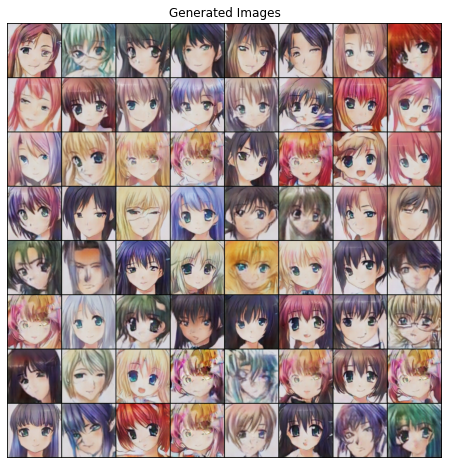

In [11]:
gen_data = generator(baseline_inputs.to(device))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(gen_data.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

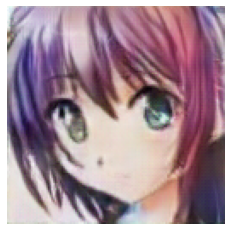

In [12]:
plt.axis("off")
plt.imshow(np.transpose(torchvision.utils.make_grid(gen_data[24].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))